In [71]:
import math


class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  def log(self):
    x = self.data
    out = Value(math.log(x), (self,), 'log')

    def _backward():
        self.grad += 1.0 / x * out.grad
    out._backward = _backward

    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [72]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [82]:
x1 = [
    [1,0,0,0,0],
    [0,0,0,1,0],
    [0,1,0,0,0],
    [0,0,1,0,0]
]

x = [
    [1,0,0,0,0],
]


w1 = [

[ 0.2963, 1.1951, 0.7433, -0.1034, -0.6192],

[ 2.6439, 1.7843, 0.2086, 0.5000, 0.4406], 

[-0.6386, 0.2266, -0.0906, -0.3895, -0.2717],

[-0.2562, -0.7472, -0.8306, -1.2820, 0.2468],

[-1.3791, -1.8291, -0.4827, 0.2922, 0.4291]

]


w = [

[ 0.2963, 1.1951, 0.7433],

[ 2.6439, 1.7843, 0.2086], 

[-0.6386, 0.2266, -0.0906]

]


In [83]:
import numpy as np

# inputs x1,x2
x = [[Value(v, label=f"xR{row}C{col}") for col,v in enumerate(input)] for row,input in enumerate(x)]
w = [[Value(weight, label=f"wR{row}C{col}")  for col,weight in enumerate(weights)] for row,weights in enumerate(w)]

def getNeuron(num):
    np_w = np.array(w)
    column = np.take(np_w, num, axis=1)
    return column


final_output = []
for inputs in x:
    output = []
    for i in range(len(w[0])):
        neuron = getNeuron(i)
        for a,b in zip(neuron, inputs):
            print(f"{a.label}-{b.label}")
        output.append(sum(a*b for a,b in zip(neuron, inputs)))

    final_output.append(output)

out = final_output  



wR0C0-xR0C0
wR1C0-xR0C1
wR2C0-xR0C2
wR0C1-xR0C0
wR1C1-xR0C1
wR2C1-xR0C2
wR0C2-xR0C0
wR1C2-xR0C1
wR2C2-xR0C2


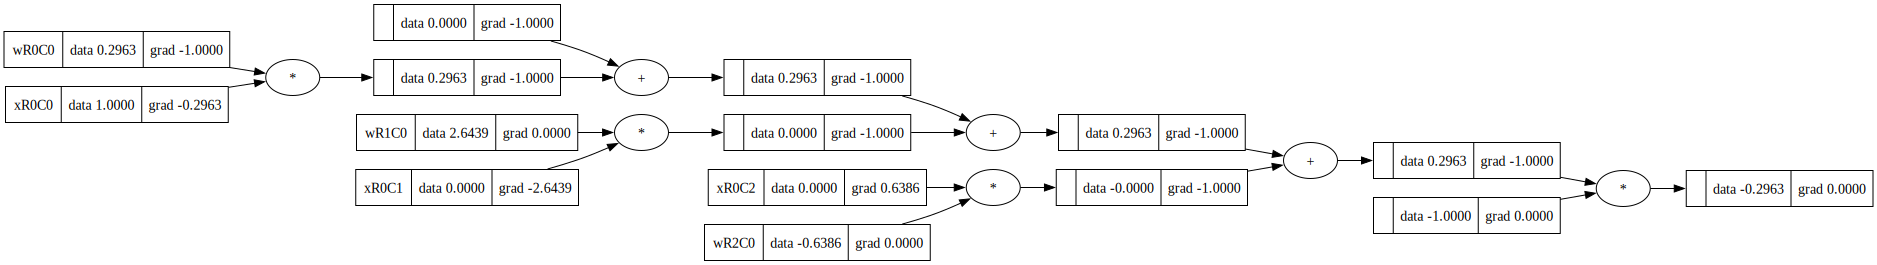

In [78]:

#probs =  out[0][3].exp().log() +  out[1][1].exp().log() + out[2][2].exp().log()

probs =  out[0][0]
loss = -probs
draw_dot(loss)

In [77]:
# for p in w.parameters():
#     p.grad = 0.0

loss.backward()

In [ ]:
print([[ weight.grad for weight in weights] for weights in w])

In [ ]:
print([[ weight.data for weight in weights] for weights in w])

In [ ]:
 # This will open the rendered graph in your default viewer
